In [ ]:
### BEWARE:Tensorflow is stochastic - this means the model will not be replicated exactly. 
### Use GA_Load_Model for reproduction

#!pip install mlxtend

#!pip install h5py pyyaml



#!pip install tensorflow

In [ ]:
#Load packages

%load_ext tensorboard

%matplotlib inline

In [ ]:
### Packages necessary for model construction 

import tensorflow as tf
import tensorflow.keras.callbacks
import datetime 
import statistics

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os 

from matplotlib import pyplot as plt

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn

import pydot

In [ ]:
#Read the Data

UN_Data = pd.read_csv('SC_Query_Clean')

UN_Data

,Unnamed: 0,dates,Class M,Class S,Class I,Class P,Policy Passed,Conflict Indicator
0,0,2017,1,0,0,0,0,1
1,1,2013,1,0,0,1,0,1
2,2,2018,1,0,0,0,0,1
3,3,2016,1,0,1,0,0,0
4,4,1995,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5082,5082,2017,1,0,0,0,0,1
5083,5083,2017,1,0,0,0,0,1
5084,5084,2002,0,0,0,0,0,0
5085,5085,2018,1,0,0,0,0,1


In [ ]:
#Inspect and Clean the Data

UN_Data.head(5)

UN_Data.drop(['Unnamed: 0'], axis = 1, inplace= True)

UN_Data

,dates,Class M,Class S,Class I,Class P,Policy Passed,Conflict Indicator
0,2017,1,0,0,0,0,1
1,2013,1,0,0,1,0,1
2,2018,1,0,0,0,0,1
3,2016,1,0,1,0,0,0
4,1995,1,0,0,0,0,0
...,...,...,...,...,...,...,...
5082,2017,1,0,0,0,0,1
5083,2017,1,0,0,0,0,1
5084,2002,0,0,0,0,0,0
5085,2018,1,0,0,0,0,1


In [ ]:
#Balance Policy Passage

# Count samples per class
classes_zero = UN_Data[UN_Data['Policy Passed'] == 0]
classes_one = UN_Data[UN_Data['Policy Passed'] == 1]

# Convert parts into NumPy arrays for weight computation
zero_numpy = classes_zero['Policy Passed'].to_numpy()
one_numpy = classes_one['Policy Passed'].to_numpy()
all_together = np.concatenate((zero_numpy, one_numpy))
unique_classes = np.unique(all_together)

# Compute weights
weights = sklearn.utils.class_weight.compute_class_weight('balanced', unique_classes, all_together)
weights = dict(enumerate(weights))
print(weights)

{0: 0.7088907469342252, 1: 1.6967978652434956}


In [ ]:
#Inspect the data by key descriptive statistics

UN_Data.describe()

,dates,Class M,Class S,Class I,Class P,Policy Passed,Conflict Indicator
count,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000
mean,2007.883428,0.930214,0.064478,0.038530,0.064085,0.294673,0.487124
std,7.211264,0.288127,0.530036,0.228025,0.251268,0.455940,0.499883
min,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,2019.000000,5.000000,21.000000,6.000000,3.000000,1.000000,1.000000


In [ ]:
#Group the data by our label (dependent variable) of policy passage

UN_Data.groupby(['Policy Passed']).count()

,dates,Class M,Class S,Class I,Class P,Conflict Indicator
Policy Passed,,,,,,
0,3588,3588,3588,3588,3588,3588
1,1499,1499,1499,1499,1499,1499


In [ ]:
#Normalize the data 

UN_Data1 = tf.keras.utils.normalize(UN_Data.drop(columns = ['Policy Passed']))

UN_Data1['Policy Passed'] = UN_Data['Policy Passed']

UN_Data1.describe()

,dates,Class M,Class S,Class I,Class P,Conflict Indicator,Policy Passed
count,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000
mean,9.999998e-01,0.000463,0.000032,0.000019,0.000032,0.000242,0.294673
std,9.004761e-07,0.000143,0.000263,0.000113,0.000125,0.000249,0.455940
min,9.999455e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.999998e-01,0.000496,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.999999e-01,0.000498,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.999999e-01,0.000499,0.000000,0.000000,0.000000,0.000497,1.000000
max,1.000000e+00,0.002480,0.010416,0.002972,0.001494,0.000502,1.000000


In [ ]:
#Divide our variables between the independent variables (features) and dependent variables (policy passage)

labels = UN_Data1 ['Policy Passed']
features = UN_Data1.drop(columns= ['Policy Passed', 'Conflict Indicator'])

In [ ]:
#Drop Null Values

features = features.fillna(0)
labels = labels.fillna(0)

In [ ]:
#Inspect shape of features

features = pd.get_dummies(features)
features.shape[0:5]

(5087, 5)

In [ ]:
#Define type of feature and label values

features = features.values.astype('float32')
labels = labels.values.astype('float32')

In [ ]:
#Data Sets for Training

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2)
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, test_size=0.2)

In [ ]:
#Define Precision, Recall, and F1 score metrics
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras

def precision(y_true, y_pred):
    weights = sklearn.utils.class_weight.compute_class_weight('balanced', unique_classes, all_together)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

In [ ]:
#Create your model

model1 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'), keras.layers.Dense(1, activation='sigmoid')])
model2 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model3 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model4 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model5 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])

model6 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model7 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model8 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model9 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model10 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])

model11 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model12 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model13 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model14 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model15 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])

model16 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model17 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model18 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model19 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model20 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])

model21 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model22 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model23 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model24 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model25 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])

model26 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model27 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model28 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model29 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])
model30 = tf.keras.Sequential([keras.layers.Dense(124, input_shape=(5,)),keras.layers.Dropout(.15),keras.layers.Dense(64, activation= 'relu'),keras.layers.Dropout(.2),keras.layers.Dense(16, activation= 'relu'),keras.layers.Dense(1, activation='sigmoid')])

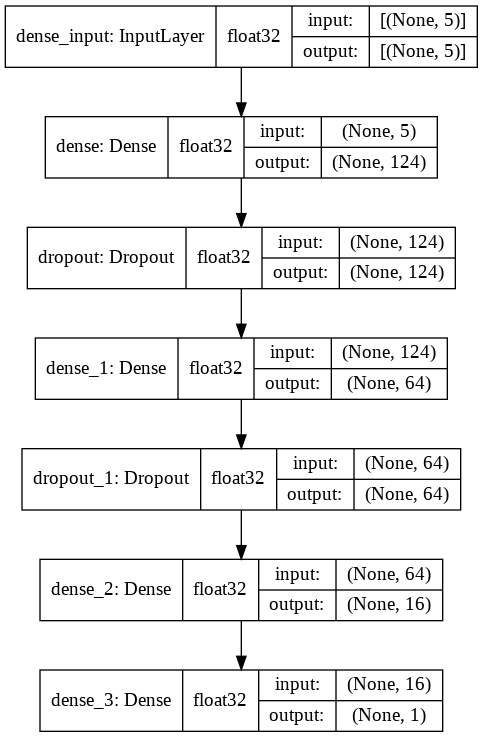

In [ ]:
### Inspect form of model

tf.keras.utils.plot_model(model1, to_file='model.png', show_shapes = True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [ ]:
#Check Trainable Parameters
# Note: All the models are similarly structured

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 124)               744       
_________________________________________________________________
dropout (Dropout)            (None, 124)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 9,801
Trainable params: 9,801
Non-trainable params: 0
______________________________________________________

In [ ]:
#Set checkpoints, metrics, loss, and optimizer functions for the model

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model5.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])

model6.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model7.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model8.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model9.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model10.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])

model11.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model12.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model13.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model14.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model15.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])

model16.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model17.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model18.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model19.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model20.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])

model21.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model22.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model23.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model24.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model25.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])

model26.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model27.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model28.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model29.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])
model30.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc', precision, recall, f1_metric, tf.keras.metrics.AUC()])

In [ ]:
#Run the model

print("Model 1 Fitting")
history1 = model1.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 2 Fitting")
history2 = model2.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 3 Fitting")
history3 = model3.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 4 Fitting")
history4 = model4.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 5 Fitting")
history5 = model5.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])

print("Model 6 Fitting")
history6 = model6.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 7 Fitting")
history7 = model7.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 8 Fitting")
history8 = model8.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 9 Fitting")
history9 = model9.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 10 Fitting")
history10 = model10.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])

print("Model 11 Fitting")
history11 = model11.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 12 Fitting")
history12 = model12.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 13 Fitting")
history13 = model13.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 14 Fitting")
history14 = model14.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 15 Fitting")
history15 = model15.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])

print("Model 16 Fitting")
history16 = model16.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 17 Fitting")
history17 = model17.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 18 Fitting")
history18 = model18.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 19 Fitting")
history19 = model19.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 20 Fitting")
history20 = model20.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])

print("Model 21 Fitting")
history21 = model21.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 22 Fitting")
history22 = model22.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 23 Fitting")
history23 = model23.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 24 Fitting")
history24 = model24.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 25 Fitting")
history25 = model25.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])

print("Model 26 Fitting")
history26 = model26.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 27 Fitting")
history27 = model27.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 28 Fitting")
history28 = model28.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 29 Fitting")
history29 = model29.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])
print("Model 30 Fitting")
history30 = model30.fit(features_train, labels_train, epochs=30, validation_data=(features_validation, labels_validation), class_weight = weights, callbacks=[tensorboard_callback])

Model 1 Fitting
Epoch 1/30
102/102 [==============================] - 4s 10ms/step - loss: 0.7028 - acc: 0.4296 - precision: 0.3128 - recall: 0.7164 - f1_metric: 0.4017 - auc: 0.5078 - val_loss: 0.7211 - val_acc: 0.2715 - val_precision: 0.2687 - val_recall: 1.0000 - val_f1_metric: 0.4144 - val_auc: 0.5000
Epoch 2/30
102/102 [==============================] - 0s 2ms/step - loss: 0.6942 - acc: 0.4093 - precision: 0.2925 - recall: 0.7289 - f1_metric: 0.3937 - auc: 0.4921 - val_loss: 0.7104 - val_acc: 0.2715 - val_precision: 0.2687 - val_recall: 1.0000 - val_f1_metric: 0.4144 - val_auc: 0.5000
Epoch 3/30
102/102 [==============================] - 0s 2ms/step - loss: 0.6957 - acc: 0.4335 - precision: 0.3054 - recall: 0.6707 - f1_metric: 0.3800 - auc: 0.5071 - val_loss: 0.7283 - val_acc: 0.2715 - val_precision: 0.2687 - val_recall: 1.0000 - val_f1_metric: 0.4144 - val_auc: 0.5000
Epoch 4/30
102/102 [==============================] - 0s 2ms/step - loss: 0.6991 - acc: 0.4428 - precision: 0.302

In [ ]:
#Run model predictions

# Model 1 
prediction_features_1 = model1.predict(features_test)
performance1 = model1.evaluate(features_test, labels_test)
print(performance1)
# Model 2 
prediction_features_2 = model2.predict(features_test)
performance2 = model2.evaluate(features_test, labels_test)
print(performance1)
# Model 3 
prediction_features_3 = model3.predict(features_test)
performance3 = model3.evaluate(features_test, labels_test)
print(performance1)
# Model 4 
prediction_features_4 = model4.predict(features_test)
performance4 = model4.evaluate(features_test, labels_test)
print(performance4)
# Model 5 
prediction_features_5 = model5.predict(features_test)
performance5 = model5.evaluate(features_test, labels_test)
print(performance5)

# Model 6 
prediction_features_6 = model6.predict(features_test)
performance6 = model6.evaluate(features_test, labels_test)
print(performance6)
# Model 7
prediction_features_7 = model7.predict(features_test)
performance7 = model7.evaluate(features_test, labels_test)
print(performance7)
# Model 8 
prediction_features_8 = model8.predict(features_test)
performance8 = model8.evaluate(features_test, labels_test)
print(performance8)
# Model 9
prediction_features_9 = model9.predict(features_test)
performance9 = model9.evaluate(features_test, labels_test)
print(performance9)
# Model 10
prediction_features_10 = model10.predict(features_test)
performance10 = model10.evaluate(features_test, labels_test)
print(performance10)

# Model 11 
prediction_features_11 = model11.predict(features_test)
performance11 = model11.evaluate(features_test, labels_test)
print(performance11)
# Model 12 
prediction_features_12 = model12.predict(features_test)
performance12 = model12.evaluate(features_test, labels_test)
print(performance12)
# Model 13 
prediction_features_13 = model13.predict(features_test)
performance13 = model13.evaluate(features_test, labels_test)
print(performance13)
# Model 14 
prediction_features_14 = model14.predict(features_test)
performance14 = model14.evaluate(features_test, labels_test)
print(performance14)
# Model 15 
prediction_features_15 = model15.predict(features_test)
performance15 = model15.evaluate(features_test, labels_test)
print(performance15)

# Model 16
prediction_features_16 = model16.predict(features_test)
performance16 = model16.evaluate(features_test, labels_test)
print(performance16)
# Model 17
prediction_features_17 = model17.predict(features_test)
performance17 = model17.evaluate(features_test, labels_test)
print(performance17)
# Model 18 
prediction_features_18 = model18.predict(features_test)
performance18 = model18.evaluate(features_test, labels_test)
print(performance18)
# Model 19
prediction_features_19 = model19.predict(features_test)
performance19 = model19.evaluate(features_test, labels_test)
print(performance19)
# Model 20 
prediction_features_20 = model20.predict(features_test)
performance20 = model20.evaluate(features_test, labels_test)
print(performance20)

# Model 21
prediction_features_21 = model21.predict(features_test)
performance21 = model21.evaluate(features_test, labels_test)
print(performance21)
# Model 22
prediction_features_22 = model22.predict(features_test)
performance22 = model22.evaluate(features_test, labels_test)
print(performance22)
# Model 23
prediction_features_23 = model23.predict(features_test)
performance23 = model23.evaluate(features_test, labels_test)
print(performance23)
# Model 24 
prediction_features_24 = model24.predict(features_test)
performance24 = model24.evaluate(features_test, labels_test)
print(performance24)
# Model 25
prediction_features_25 = model25.predict(features_test)
performance25 = model25.evaluate(features_test, labels_test)
print(performance25)

# Model 26 
prediction_features_26 = model26.predict(features_test)
performance26 = model26.evaluate(features_test, labels_test)
print(performance26)
# Model 27 
prediction_features_27 = model27.predict(features_test)
performance27 = model27.evaluate(features_test, labels_test)
print(performance27)
# Model 28 
prediction_features_28 = model28.predict(features_test)
performance28 = model28.evaluate(features_test, labels_test)
print(performance28)
# Model 29
prediction_features_29 = model29.predict(features_test)
performance29 = model29.evaluate(features_test, labels_test)
print(performance29)
# Model 30 
prediction_features_30 = model30.predict(features_test)
performance30 = model30.evaluate(features_test, labels_test)
print(performance30)

32/32 [==============================] - 0s 1ms/step - loss: 0.6959 - acc: 0.3026 - precision: 0.3030 - recall: 1.0000 - f1_metric: 0.4591 - auc: 0.5000
[0.6958709955215454, 0.30255404114723206, 0.30303484201431274, 1.0, 0.45905670523643494, 0.5]
32/32 [==============================] - 0s 1ms/step - loss: 0.6961 - acc: 0.3026 - precision: 0.3030 - recall: 1.0000 - f1_metric: 0.4591 - auc_1: 0.5000
[0.6958709955215454, 0.30255404114723206, 0.30303484201431274, 1.0, 0.45905670523643494, 0.5]
32/32 [==============================] - 0s 1ms/step - loss: 0.6968 - acc: 0.3026 - precision: 0.3030 - recall: 1.0000 - f1_metric: 0.4591 - auc_2: 0.5000
[0.6958709955215454, 0.30255404114723206, 0.30303484201431274, 1.0, 0.45905670523643494, 0.5]
32/32 [==============================] - 0s 1ms/step - loss: 0.6969 - acc: 0.3026 - precision: 0.3030 - recall: 1.0000 - f1_metric: 0.4591 - auc_3: 0.5000
[0.696880578994751, 0.30255404114723206, 0.30303484201431274, 1.0, 0.45905670523643494, 0.5]
32/32 [

In [ ]:
# Averages

# Loss
loss_avg = (performance1[0] + performance2[0] + performance3[0] + performance4[0] + performance5[0] + performance6[0] + performance7[0] + performance8[0] + performance9[0] + performance10[0]
            + performance11[0] + performance12[0] + performance13[0] + performance14[0] + performance15[0] + performance16[0] + performance17[0] + performance18[0] + performance19[0] + performance20[0]
            + performance21[0] + performance22[0] + performance23[0] + performance24[0] + performance25[0] + performance26[0] + performance27[0] + performance28[0] + performance29[0] + performance30[0])/30
print("Loss Average: ", loss_avg)

# Accuracy
acc_avg =(performance1[1] + performance2[1] + performance3[1] + performance4[1] + performance5[1] + performance6[1] + performance7[1] + performance8[1] + performance9[1] + performance10[1]
            + performance11[1] + performance12[1] + performance13[1] + performance14[1] + performance15[1] + performance16[1] + performance17[1] + performance18[1] + performance19[1] + performance20[1]
            + performance21[1] + performance22[1] + performance23[1] + performance24[1] + performance25[1] + performance26[1] + performance27[1] + performance28[1] + performance29[1] + performance30[1])/30
print("Accuraccy Average: ", acc_avg)

# Precision
precision_avg = (performance1[2] + performance2[2] + performance3[2] + performance4[2] + performance5[2] + performance6[2] + performance7[2] + performance8[2] + performance9[2] + performance10[2]
            + performance11[2] + performance12[2] + performance13[2] + performance14[2] + performance15[2] + performance16[2] + performance17[2] + performance18[2] + performance19[2] + performance20[2]
            + performance21[2] + performance22[2] + performance23[2] + performance24[2] + performance25[2] + performance26[2] + performance27[2] + performance28[2] + performance29[2] + performance30[2])/30
print("Precision Average: ", precision_avg)

# Recall
recall_avg = (performance1[3] + performance2[3] + performance3[3] + performance4[3] + performance5[3] + performance6[3] + performance7[3] + performance8[3] + performance9[3] + performance10[3]
            + performance11[3] + performance12[3] + performance13[3] + performance14[3] + performance15[3] + performance16[3] + performance17[3] + performance18[3] + performance19[3] + performance20[3]
            + performance21[3] + performance22[3] + performance23[3] + performance24[3] + performance25[3] + performance26[3] + performance27[3] + performance28[3] + performance29[3] + performance30[3])/30
print("Recall Average: ", recall_avg)

# f1_metric
f1_avg = (performance1[4] + performance2[4] + performance3[4] + performance4[4] + performance5[4] + performance6[4] + performance7[4] + performance8[4] + performance9[4] + performance10[4]
            + performance11[4] + performance12[4] + performance13[4] + performance14[4] + performance15[4] + performance16[4] + performance17[4] + performance18[4] + performance19[4] + performance20[4]
            + performance21[4] + performance22[4] + performance23[4] + performance24[4] + performance25[4] + performance26[4] + performance27[4] + performance28[4] + performance29[4] + performance30[4])/30
print("F1 Average: ", f1_avg)

auc_avg = (performance1[5] + performance2[5] + performance3[5] + performance4[5] + performance5[5] + performance6[5] + performance7[5] + performance8[5] + performance9[5] + performance10[5]
            + performance11[5] + performance12[5] + performance13[5] + performance14[5] + performance15[5] + performance16[5] + performance17[5] + performance18[5] + performance19[5] + performance20[5]
            + performance21[5] + performance22[5] + performance23[5] + performance24[5] + performance25[5] + performance26[5] + performance27[5] + performance28[5] + performance29[5] + performance30[5])/30
print("AUC Average: ", auc_avg)

Loss Average:  0.6965337713559469
Accuraccy Average:  0.30255404114723206
Precision Average:  0.30303484201431274
Recall Average:  1.0
F1 Average:  0.45905670523643494
AUC Average:  0.5


In [ ]:
#Take the standard deviation of the model samples

#Loss SE
Loss_SE = statistics.stdev([performance1[0], performance2[0], performance3[0], performance4[0], performance5[0],
                  performance6[0], performance7[0], performance8[0], performance9[0], performance10[0],
                  performance11[0], performance12[0], performance13[0], performance14[0], performance15[0],
                  performance16[0], performance17[0], performance18[0], performance19[0], performance20[0], 
                  performance21[0], performance22[0], performance23[0], performance24[0], performance25[0],
                  performance26[0], performance27[0], performance28[0], performance29[0], performance30[0]])
print("Loss SE:", Loss_SE)

#Accuracy SE
Acc_SE = statistics.stdev([performance1[1], performance2[1], performance3[1], performance4[1], performance5[1],
                  performance6[1], performance7[1], performance8[1], performance9[1], performance10[1],
                  performance11[1], performance12[1], performance13[1], performance14[1], performance15[1],
                  performance16[1], performance17[1], performance18[1], performance19[1], performance20[1], 
                  performance21[1], performance22[1], performance23[1], performance24[1], performance25[1],
                  performance26[1], performance27[1], performance28[1], performance29[1], performance30[1]])
print("Accuraccy SE: ", Acc_SE)

#Precision SE
precision_SE = statistics.stdev([performance1[2], performance2[2], performance3[2], performance4[2], performance5[2],
                  performance6[2], performance7[2], performance8[2], performance9[2], performance10[2],
                  performance11[2], performance12[2], performance13[2], performance14[2], performance15[2],
                  performance16[2], performance17[2], performance18[2], performance19[2], performance20[2], 
                  performance21[2], performance22[2], performance23[2], performance24[2], performance25[2],
                  performance26[2], performance27[2], performance28[2], performance29[2], performance30[2]])
print("Precision SE: ", precision_SE)

#Recall 
Recall_SE = statistics.stdev([performance1[3], performance2[3], performance3[3], performance4[3], performance5[3],
                  performance6[3], performance7[3], performance8[3], performance9[3], performance10[3],
                  performance11[3], performance12[3], performance13[3], performance14[3], performance15[3],
                  performance16[3], performance17[3], performance18[3], performance19[3], performance20[3], 
                  performance21[3], performance22[3], performance23[3], performance24[3], performance25[3],
                  performance26[3], performance27[3], performance28[3], performance29[3], performance30[3]])
print("Recall SE: ", Recall_SE)

#F1 Score
F1_Score_SE = statistics.stdev([performance1[4], performance2[4], performance3[4], performance4[4], performance5[4],
                  performance6[4], performance7[4], performance8[4], performance9[4], performance10[4],
                  performance11[4], performance12[4], performance13[4], performance14[4], performance15[4],
                  performance16[4], performance17[4], performance18[4], performance19[4], performance20[4], 
                  performance21[4], performance22[4], performance23[4], performance24[4], performance25[4],
                  performance26[4], performance27[4], performance28[4], performance29[4], performance30[4]])
print("F1_Score_SE: ", F1_Score_SE)


#AUC 
AUC_SE = statistics.stdev([performance1[5], performance2[5], performance3[5], performance4[5], performance5[5] , performance6[5], performance7[5], performance8[5], performance9[5], performance10[5], 
           performance11[5], performance12[5],performance13[5],performance14[5], performance15[5], performance16[5], performance17[5], performance18[5], performance19[5], performance20[5],
           performance21[5], performance22[5], performance23[5], performance24[5], performance25[5], performance26[5], performance27[5], performance28[5], performance29[5], performance30[5]])
print("AUC SE: ", AUC_SE)

Loss SE: 0.0015223629855242178
Accuraccy SE:  0.0
Precision SE:  0.0
Recall SE:  0.0
F1_Score_SE:  0.0
AUC SE:  0.0


In [ ]:
#Tensorflow Graphics

%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>